# Sea Ice Indicators Update

##### 2020-12-18

This report presents a summary of the relevant pieces of the [NSIDC-0747 data set](https://nsidc.org/data/NSIDC-0747/versions/1) and a comparison with the results of the most recent version of the algorithm for defining sea ice Freeze-up/Break-up (FUBU) dates.

In [1]:
def plot_counts(orac_ds, variables, titles):
    """Count valid dates by metric and create plot"""
    def prep_data(var):
        arr = orac_ds[var].values
        valid = arr > 0
        counts = np.sum(valid, axis=0)
        plot_arr = np.ma.masked_where(arr[0] == -4, counts)
        plot_arr[plot_arr == -5] = 0
        return plot_arr.astype("int32")
    
    plot_arrs = [prep_data(var) for var in variables]
    
    # plot data
    cmap = copy.copy(plt.cm.get_cmap("viridis"))
    cmap.set_bad(color="black")
    fig, axs = plt.subplots(1, 2, figsize=(12,8))
    for arr,ax,title in zip(plot_arrs, axs, titles):
        im = ax.imshow(arr, interpolation="none", cmap=cmap, vmin=0, vmax=39)
        ax.title.set_text(title)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.2, 0.04, 0.6])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    
    return None

def plot_date_diff_comparison(ds1, ds2, vars1, vars2, titles):
    """Plot the mean difference in days between 
    fubu metrics for two data sets where both are defined
    """
    def prep_data(ds, variable):
        # our algorithm
        fubu_vars = ["freezeup_start", "freezeup_end", "breakup_start", "breakup_end"]
        arr = ds[variable].values.copy()
        if variable in ["DOO", "DOC", "DOR", "DOA"]:
            arr[arr <= 0] = np.nan
        return arr
    
    orac_arrs = np.array([prep_data(ds1, var) for var in vars1])
    fubu_arrs = np.array([prep_data(ds2, var) for var in vars2])
    # compute difference as lag between fubu dates and oarc dates
    lag_arrs = fubu_arrs - orac_arrs
    # compute mean differences
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        mean_lag_arrs = np.array([np.nanmean(arr, axis=0) for arr in lag_arrs])
    # set all NaNs to zero and land mask to NaN
    mean_lag_arrs[np.isnan(mean_lag_arrs)] = 0
    mean_lag_arrs[ds1.DOO.values[:2] == -4] = np.nan
    
    cmap = copy.copy(plt.cm.get_cmap("coolwarm"))
    cmap.set_bad(color="black")
    # set diverging color map
    divnorm = colors.TwoSlopeNorm(
        vmin=np.nanmin(mean_lag_arrs), 
        vcenter=0, 
        vmax=np.nanmax(mean_lag_arrs)
    )
    fig, axs = plt.subplots(1, 2, figsize=(12,8))
    for arr,ax,title in zip(mean_lag_arrs, axs, titles):
        im = ax.imshow(
            arr, 
            interpolation="none", 
            cmap=cmap, 
            norm=divnorm
        )
        ax.title.set_text(title)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.2, 0.04, 0.6])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    
    return None


def plot_dates_hist_comparison(ds1, ds2, vars1, vars2, titles):
    """Count valid dates by metric and create plot of histograms"""
    def prep_data(ds, variable):
        """Extract indicator and prepare for histogram"""
        # our algorithm
        fubu_vars = ["freezeup_start", "freezeup_end", "breakup_start", "breakup_end"]
        arr = ds[variable].values
        if variable in ["DOO", "DOC", "DOR", "DOA"]:
            arr[arr <= 0] = np.nan

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            dates = np.nanmean(arr, axis=0)

        return dates[~np.isnan(dates)] 

    orac_args = [{"arr":prep_data(ds1, var), "label":var} for var in vars1]
    fubu_args = [{"arr":prep_data(ds2, var), "label":var} for var in vars2]
    plot_args = zip(orac_args, fubu_args)
    
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    for args,ax,title in zip(plot_args, axs, titles):
        _ = [ax.hist(d["arr"], alpha=0.5, label=d["label"]) for d in args]
        ax.title.set_text(title)
        ax.legend(loc='upper right')
    plt.legend()
    plt.show()
    
    return None

In [2]:
import os, copy, warnings
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import rasterio as rio
import xarray as xr
from pathlib import Path

In [3]:
base_dir = Path(os.getenv("BASE_DIR"))
fubu_fn = "nsidc_0051_sic_nasateam_1979-2018_north_smoothed_fubu_dates.nc"
# computed fubu dates fp
fubu_fp = base_dir.joinpath("nsidc_0051", "outputs", "NetCDF", fubu_fn)
# sample fp for mask
samp_fp = base_dir.joinpath("nsidc_0051", "scratch", "nsidc_sample_20181231.tif")
# load fubu dates netCDF
fubu_ds = xr.load_dataset(fubu_fp)
# with rio.open(samp_fp) as src:
#     # defined for global reference
#     SAMP_ARR = src.read(1)
# ice opening, retreating, advancing, closing
orac_fp = base_dir.joinpath("nsidc_0747", "arctic_seaice_climate_indicators_nh_v01r01_1979-2017.nc")
orac_ds = xr.load_dataset(orac_fp)

# NSIDC-0747 comparison

## Freeze-up

The analogs for freeze-up start and end appear to be ice "advance" (first day SIC increases above 15%) and "close" (first day SIC increases above 80%).

### Totals maps

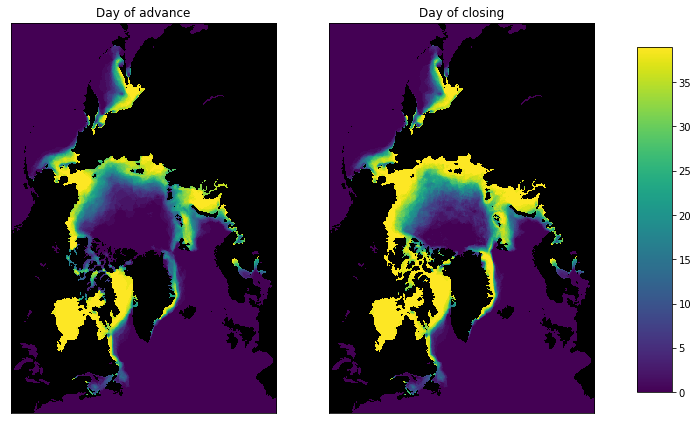

In [4]:
orac_vars = ("DOA", "DOC")
orac_titles = ("Day of advance", "Day of closing")
plot_counts(orac_ds, orac_vars, orac_titles)

### Mean lagged-date maps

These maps present the mean lag in days between the indicators computed from our current algorithm and the NSIDC-0747 data set, where both values are defined. I.e., the value displayed in each grid cell is calculated as:

$mean(indicator_{current} - indicator_{NSIDC0747})$

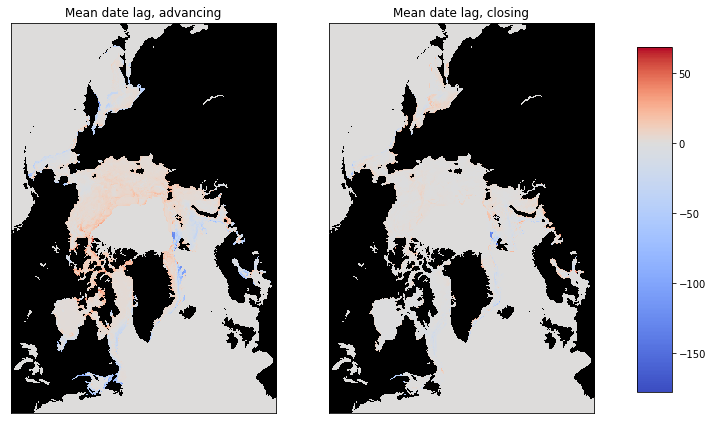

In [5]:
fubu_vars = ["freezeup_start", "freezeup_end"]
plot_date_diff_comparison(
    orac_ds,
    fubu_ds,
    orac_vars,
    fubu_vars,
    ("Mean date lag, advancing", "Mean date lag, closing")
)

### Mean date histograms

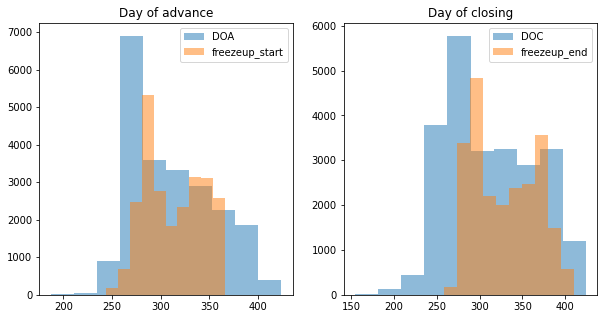

In [6]:
plot_dates_hist_comparison(
    orac_ds,
    fubu_ds,
    orac_vars,
    fubu_vars,
    orac_titles
)

## Break-up

The analogs for break-up start and end appear to be ice "retreating" (last day SIC drops below 15%) and "open" (last day SIC is above 80%).

### Totals maps

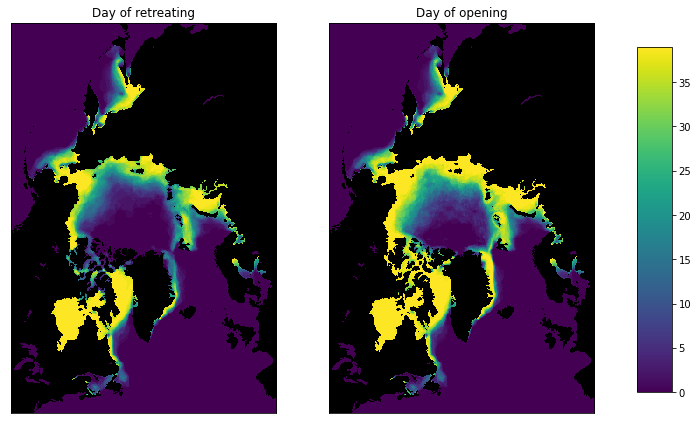

In [7]:
orac_vars = ("DOR", "DOO")
orac_titles = ("Day of retreating", "Day of opening")
plot_counts(orac_ds, orac_vars, orac_titles)

### Mean lagged-date maps

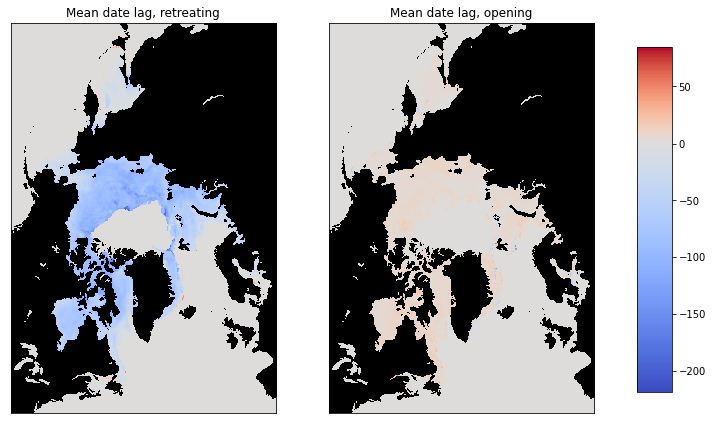

In [8]:
fubu_vars = ["breakup_start", "breakup_end"]
plot_date_diff_comparison(
    orac_ds,
    fubu_ds,
    orac_vars,
    fubu_vars,
    ("Mean date lag, retreating", "Mean date lag, opening")
)

### Mean date histograms

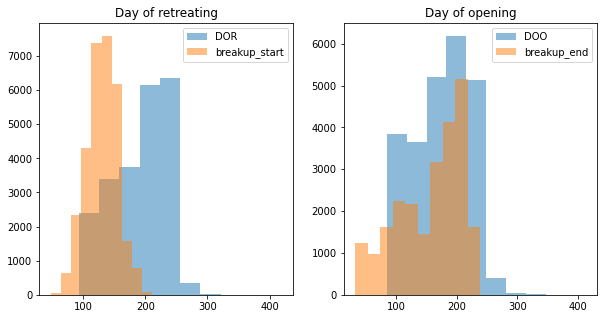

In [9]:
plot_dates_hist_comparison(
    orac_ds,
    fubu_ds,
    orac_vars,
    ["breakup_start", "breakup_end"],
    orac_titles
)